<a href="https://colab.research.google.com/github/norgaston/proyecto-final-mlbd/blob/main/Proyecto_Final_KMEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Final: Segmentación de clientes con KMEANS**



**ELEMENTOS DE APRENDIZAJE DE MÁQUINA Y BIG DATA**

Carrera: T.U. TECNOLOGÍAS DE PROGRAMACIÓN SEDE PUNTA ALTA

Facultad: Facultad de la Micro, Pequeña y Mediana Empresa (UPSO)

Docente: Valentín Barco

Cuatrimestre/Año: 2° Cuatrimestre 2023

Alumnos: Dolores Ponce y Gaston Ponce (Grupo 12)

## **Introducción**

Un shopping recolectó información anónima de los clientes para implementar nuevas
estratégias de marketing y lograr aumentar las ventas.
Los clientes brindaron la siguiente información:
- Sexo
- Edad
- Ingresos semanales (en miles de pesos)

Quienes recolectaron la información agregaron un número de identificación a cada cliente y
un puntaje de acuerdo a su personalidad y a las compras realizadas. Este puntaje va desde
0 (peor cliente) a 100 (mejor cliente).


# **Bibliotecas necesarias**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.utils import shuffle

# **Carga de los datos**

In [2]:
ruta = '/content/clientes-kmeans.csv' # ruta desde donde voy a cargar el dataset
df = pd.read_csv(ruta, index_col='id') # leo el csv, y dejo la columna 'id' como índice

# **Análisis exploratorio y limpieza de datos**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   sexo                       200 non-null    object
 1   edad                       200 non-null    int64 
 2   ingresosSemanales(miles$)  200 non-null    int64 
 3   puntaje(1-100)             200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


En principio lo que quiero obtener son los distintos grupos de clientes, sin tener en cuenta el género de cada uno. Me interesa clasificarlos en función del puntaje que tengan, la edad y los ingresos. Una vez que tenga los grupos, puedo plantearme la necesidad de saber el género de los integrantes de cada grupo y hacer algún análisis para llevar adelante una estrategia de marketing, por ejemplo. Un punto importante es que Kmeans no funciona bien con variables categóricas, en este caso el género, por lo que tampoco sería conveniente usarlo.

Contestando a la pregunta de si es necesario utilizar todos los datos brindados, la respuesta es no, ya que el id es un dato irrelevante para el análisis, y el género, como escribí antes, no sería ideal usarlo en Kmeans.

In [4]:
df.drop(columns=['sexo'], inplace=True) # descarto la columna del género
print(df.describe())
df

             edad  ingresosSemanales(miles$)  puntaje(1-100)
count  200.000000                 200.000000      200.000000
mean    38.850000                  60.560000       50.200000
std     13.969007                  26.264721       25.823522
min     18.000000                  15.000000        1.000000
25%     28.750000                  41.500000       34.750000
50%     36.000000                  61.500000       50.000000
75%     49.000000                  78.000000       73.000000
max     70.000000                 137.000000       99.000000


,edad,ingresosSemanales(miles$),puntaje(1-100)
id,,,
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40
...,...,...,...
196,35,120,79
197,45,126,28
198,32,126,74


# **Preparación de los datos**

Como los datos que tengo están en el mismo rango, según mi punto de vista, me parece innecesario normalizarlos. De todas formas probé hacerlo, y al analizar los resultados, no me convencieron, y preferí dejarlo sin normalizar.

Lo que voy a intentar es encontrar el número de clusters óptimos utilizando el "método del codo" y el resultado de otros índices para tomar la decisión.

In [5]:
# scaler = StandardScaler()
# df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# df

# **Búsqueda del número óptimo de clústeres**

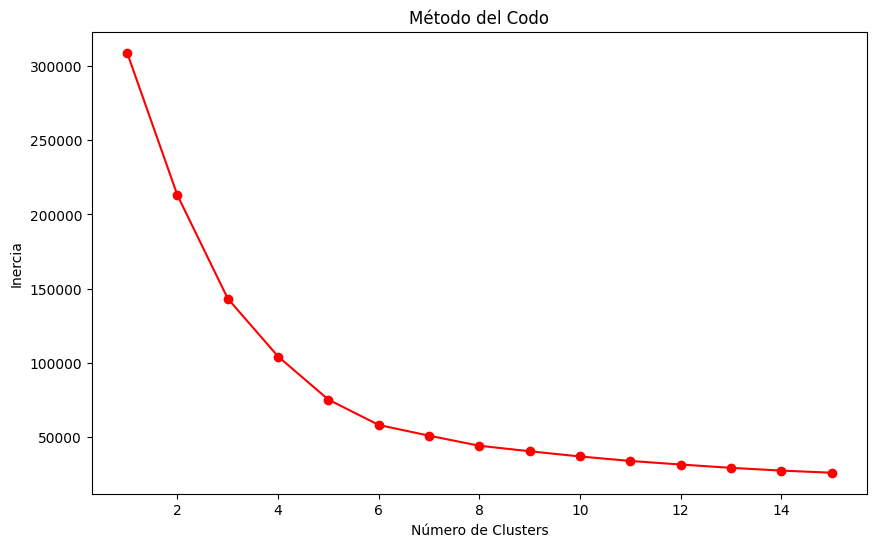

In [6]:
# Calculo el algoritmo de agrupación para diferentes valores de K
inercia = []
for i in range(1, 16):
    algoritmo = KMeans(n_clusters = i, init = 'k-means++',
                       max_iter = 1000, n_init = 100)
    algoritmo.fit(df)
    # Para cada K, se calcula la suma total del cuadrado dentro del clúster
    inercia.append(algoritmo.inertia_)
# Grafico curva de la suma de errores cuadráticos
plt.figure(figsize=[10,6])
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.plot(list(range(1, 16)), inercia, marker='o', color="red")
plt.show()

Ahora voy a analizar los datos con un K=5, que me parece el más apropiado para este caso. Podría haber usado el de K=6, con mejor resultado en las métricas, pero teniendo en cuenta los grupos obtenidos y la interpretacion de los resultados de los mismos, con K=5 me parece mejor en la práctica, y se destinarían menos recursos para su análisis posterior. Lo que pasaba básicamente es que con un k=6, me dividía en dos el grupo 1 (rojo, clientes normales) a partir de las edades, cuando lo podría tratar como un grupo único con personas de todas las edades.

# **Creación del modelo de clasificación**

In [7]:
km = KMeans(n_clusters=5, n_init=100, max_iter=1000, init='random', random_state=0) # kmeans con 5 clusters
pred = km.fit_predict(df) # fit_predict nos dice a que cluster pertenece cada observación

"""
El índice Silhouette mide la calidad del agrupamiento o clustering, la distancia de separación entre los clústers.
Nos indica como de cerca está cada punto de un clúster a puntos de los clústers vecinos. Esta medida de distancia se
encuentra en el rango [-1, 1]. Un valor alto indica un buen clustering. Los coeficientes de silueta cercanos a +1 indican
que la observación se encuentra lejos de los clústers vecinos. Un valor del coeficiente de 0 indica que la observación
está muy cerca o en la frontera de decisión entre dos clústers. Valores negativos indican que esas muestras quizás estén
asignadas al clúster erróneo.
"""

print('silhouette_score:', silhouette_score(df, pred))

"""
El índice Calinski-Harabasz se basa en la comparación de la relación ponderada entre la suma de los cuadrados
(la medida de la separación del clúster) y la suma de los cuadrados dentro del clúster (la medida de cómo se empaquetan
estrechamente los puntos dentro de un clúster). Idealmente, los clústeres deben estar bien separados, por lo que la suma
entre el valor de los cuadrados debe ser grande, pero los puntos dentro de un clúster deben estar lo más cerca posible el
uno del otro, dando como resultado valores más pequeños de la suma dentro del clúster de medida de cuadrados. Dado que el
índice Calinski-Harabasz es una relación, con la suma de los cuadrados entre el numerador y la suma de cuadrados dentro del
denominador, las soluciones de clúster con valores más grandes del índice corresponden a soluciones "mejores" que las soluciones
de clúster con valores más pequeños.
"""

print('calinski_harabasz_score:', calinski_harabasz_score(df, pred))

print('\ncluster de cada dato:', pred)
cantidad = np.unique(pred, return_counts=True)[1]
print('\ncantidad por grupo:', cantidad)

silhouette_score: 0.44428597560893024
calinski_harabasz_score: 151.0438600016067

cluster de cada dato: [1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 4 3 4 0 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 0 4 3 4 3 4
 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3
 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4]

cantidad por grupo: [79 23 23 36 39]


# **Resultados**

Ahora le agrego una columna al dataframe, donde indico a que cluster pertenece cada cliente. Después separo el dataframe principal en nuevos dataframes, uno para cada cluster.

In [8]:
df['grupoPred'] = pred
df0=df.loc[df['grupoPred']==0]
df1=df.loc[df['grupoPred']==1]
df2=df.loc[df['grupoPred']==2]
df3=df.loc[df['grupoPred']==3]
df4=df.loc[df['grupoPred']==4]
# df5=df.loc[df['grupoPred']==5]

# **Gráfico de los resultados**

Con los datos agrupados en dataframes (clusters), grafico en 3d cada unos de los puntos (edad, ingresos, puntaje) y los identifico.

In [9]:
import plotly.graph_objects as go

# Crea la figura y el eje 3D
fig = go.Figure()

# Define las etiquetas
label1 = f'Grupo 1 ({cantidad[0]})'
label2 = f'Grupo 2 ({cantidad[1]})'
label3 = f'Grupo 3 ({cantidad[2]})'
label4 = f'Grupo 4 ({cantidad[3]})'
label5 = f'Grupo 5 ({cantidad[4]})'

# Añade los puntos para cada grupo
fig.add_trace(go.Scatter3d(x=df0['edad'], y=df0['ingresosSemanales(miles$)'], z=df0['puntaje(1-100)'],
                           mode='markers', marker=dict(color='red', size=5), name=label1))

fig.add_trace(go.Scatter3d(x=df1['edad'], y=df1['ingresosSemanales(miles$)'], z=df1['puntaje(1-100)'],
                           mode='markers', marker=dict(color='yellow', size=5), name=label2))

fig.add_trace(go.Scatter3d(x=df2['edad'], y=df2['ingresosSemanales(miles$)'], z=df2['puntaje(1-100)'],
                           mode='markers', marker=dict(color='blue', size=5), name=label3))

fig.add_trace(go.Scatter3d(x=df3['edad'], y=df3['ingresosSemanales(miles$)'], z=df3['puntaje(1-100)'],
                           mode='markers', marker=dict(color='green', size=5), name=label4))

fig.add_trace(go.Scatter3d(x=df4['edad'], y=df4['ingresosSemanales(miles$)'], z=df4['puntaje(1-100)'],
                           mode='markers', marker=dict(color='magenta', size=5), name=label5))

# Añade los centroides
fig.add_trace(go.Scatter3d(x=km.cluster_centers_[:, 0], y=km.cluster_centers_[:, 1], z=km.cluster_centers_[:, 2],
                           mode='markers', marker=dict(color='lightblue', size=25), name='Centroides'))

# Personaliza el diseño del gráfico
fig.update_layout(scene=dict(xaxis_title='Edad', yaxis_title='Ingresos', zaxis_title='Puntaje'),
                  legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
                  title='Grupos de clientes')

# Muestra el gráfico
fig.show()


# **Conclusiones**

Podemos ver en el gráfico que tenemos 5 clusters, que representan 5 grupos o segmentos de clientes (los centroides están representados con las esferas grises). La visualización 3d interactiva ayuda a interpretar mejor los datos (con este código no se puede ver en Colab, por lo que usé el .py para eso)

**Grupo 1** (rojo): 79 personas de ingresos medios, con gasto medio y puntaje medio, serían los clientes "normales".

**Grupo 2** (amarillo): 23 personas con bajos ingresos y bajo puntaje, clientes que compran lo necesario, se podría estudiar qué compran.

**Grupo 3** (azul): 23 personas con bajos ingresos y alto puntaje, me podría interesar saber qué compran y por qué, entre otras cosas.

**Grupo 4** (verde): 36 personas con altos ingresos y bajo puntaje, clientes que tengo que mover a un segmento que aporte más beneficios.

**Grupo 5** (rosa): 39 personas con altos ingresos y alto puntaje, clientes que tengo que mantener en este segmento, y estudiar qué compran.

Existen dos grupos de clientes menores de 40 años y que gastan mucho, que son los azules y los rosa. Los azules con bajos ingresos y los rosa con altos ingresos, pero ambos con el mismo gasto prácticamente.
Los otros 3 grupos no están influenciados por la edad (rojo, amarillo y verde), ya que hay personas pertenecientes a dichos clusters de todas las edades.

Teniendo en cuenta los datos obtenidos, cómo obtener mejores beneficios depende de la imaginación. Como ejemplo, podría tener un día de descuento en productos que son objeto de interés del segmento objetivo, y evaluar posteriormente con Kmeans si hubo alguna variación favorable en los resultados de ese grupo, y si afectó el comportamiento de los otros por algún motivo.